# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import skimage
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")
# Directory of images to run detection on
IMAGE_DIR = os.path.join("images")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [2]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 32
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     32
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 32
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'rpn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANC

## Create Model and Load Trained Weights

In [3]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [4]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Run Object Detection

In [5]:
class ImageDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """
    def load_Imgs(self, dataset_dir, class_ids=None,
                  class_map=None, return_coco=False, auto_download=False):
        """Load a subset of the COCO dataset.
        dataset_dir: The root directory of the COCO dataset.
        subset: What to load (train, val, minival, valminusminival)
        year: What dataset year to load (2014, 2017) as a string, not an integer
        class_ids: If provided, only loads images that have the given classes.
        class_map: TODO: Not implemented yet. Supports maping classes from
            different datasets to the same class ID.
        return_coco: If True, returns the COCO object.
        auto_download: Automatically download and unzip MS-COCO images and annotations
        """
        class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']
        for i,class_name in enumerate(class_names):
            self.add_class("person", i, class_name)
        person = [];
        for _, _, filenames in os.walk(dataset_dir):
            for filename in filenames:
                if filename[-3:]=='jpg':
                    person.append(os.path.join(dataset_dir,filename))

        # Add images
        for i,img_path in enumerate(person):
            self.add_image(
                "person", image_id=i,
                path=img_path,
                width=128,
                height=64,
                annotations=[0])
    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "person":
            return info["person"]
        else:
            super(self.__class__).image_reference(self, image_id)

In [6]:
# Testing dataset
dataset_test = ImageDataset()
dataset_test.load_Imgs('../../fasion-dataset/test/')
dataset_test.prepare()

In [7]:
images = []
paths = []
i = 0
wrong = []
for image_id in dataset_test.image_ids:
# Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, config,
                           image_id, use_mini_mask=False)
    i = i + 1
    if i < 32:
        paths.append(dataset_test.image_info[image_id]['path'])
        images.append(image)
        continue
    else:
        print(image_id/len(dataset_test.image_ids))
        images.append(image)
        results = model.detect(images, verbose=1)
        for idx,path in enumerate(paths):
            result = []
            flag =0
            for i,c in enumerate(results[idx]['class_ids']):
                if c == 1:
                    file_to_save = path[0:-3]+'npy'
                    ans = results[idx]['masks']*1.0
                    dst=ans[:,:,i]
                    if sum(sum(dst))> 8000:
                        result.append(dst)
                        flag = flag + 1
            if flag == 1:
                np.save(file_to_save,result[0])
            elif flag > 1:
                for i,r in enumerate(result):
                    path0 = file_to_save[0:-3]+'_'+str(i)+'npy'
                    np.save(path0,r)
            elif flag == 0:
                wrong.append(file_to_save)
        paths = []
        images = []
        i = 0

0.007633587786259542
Processing 32 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image             

KeyboardInterrupt: 

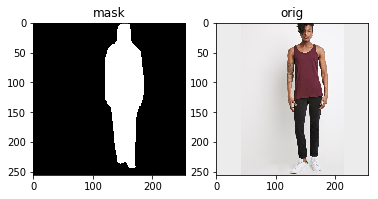

In [10]:
from skimage import io
image=io.imread(file_to_save[:-3]+'jpg')

data = np.load(file_to_save)
# data = np.load('../../market-dataset/train/0116_c6s1_019351_03.npy')
data = data[np.newaxis, :]
data = data.transpose((1,2,0))
ans = np.tile(data,(1,1,3))
plt.figure('resize')

plt.subplot(121)
plt.title('mask')
plt.imshow(ans)

plt.subplot(122)
plt.title('orig')
plt.imshow(image)


plt.show()